# Лабораторная работ №3 - "Подбор гиперпараметров модели" (ИНДИВИДУАЛЬНАЯ)

---

###### Выполнил: Найпак Дмитрий Сергеевич

###### Группа: М8О-307Б-23
###### Датасет (ссылка): [Цена мобильных телефонов](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification)

---

# Выбор модели и ее гиперпараметры

Для выполнения лабораторной работы была выбрана модель Random Forest

| Гиперпараметр       | Тип            | Описание                              | Возможные значения                     |
|---------------------|----------------|----------------------------------------|----------------------------------------|
| `n_estimators`      | `int`          | Количество деревьев в лесу             | `100`, `200`, `300`, `500`             |
| `max_depth`         | `int` или `None` | Максимальная глубина каждого дерева    | `5`, `10`, `15`, `20`, `None`          |
| `min_samples_split` | `int`          | Минимальное число объектов для разделения узла | `2`, `5`, `10`, `15`             |
| `min_samples_leaf`  | `int`          | Минимальное число объектов в листе     | `1`, `2`, `4`, `8`                     |
| `max_features`      | `str` / `float`| Количество признаков для поиска лучшего разбиения | `'sqrt'`, `'log2'`, `0.3`, `0.5`, `0.8` |
| `bootstrap`         | `bool`         | Использовать ли bootstrap-выборки      | `True`, `False`                        |
| `class_weight`      | `str` / `dict` | Веса классов для балансировки          | `None`, `'balanced'`                   |

# Выбор датасета и подготовка данных

Использован датасет с характеристиками мобильных телефонов и их ценовыми категориями.
Данные содержат цифровые и бинарные признаки.

Целевая переменная: price_range (0 - бюджетный, 1 - средний, 2 - высокий, 3 - премиум)

Импортируем необходимые модули и зафиксируем рандом.

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from scipy.stats import randint
import lime
import lime.lime_tabular
import shap
from sklearn.metrics import f1_score
from typing import List

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


Загрузим тестовый и для обучения датасеты

In [8]:
test_dataset_path = '/home/test.csv'
train_dataset_path = '/home/train.csv'

df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

print("Size train:", df_train.shape)
print("Size test:", df_test.shape)
print("Colums train:", df_train.columns.tolist())
print("Colums test:", df_test.columns.tolist())


Size train: (2000, 21)
Size test: (1000, 21)
Colums train: ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi', 'price_range']
Colums test: ['id', 'battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']


Сделаем минимальную подготовку данных, т.к деревья устойчивы к ненормализованным данным.

In [9]:

CATEGORY_NAMES = {
    0: "бюджетный",
    1: "средний",
    2: "высокий",
    3: "премиум",
}

TARGET_COL = "price_range"
ID_COL = "id"

features = [col for col in df_train.columns if col != TARGET_COL]

if ID_COL in features:
    features.remove(ID_COL)

X_train = df_train[features].copy()
y_train = df_train[TARGET_COL].copy()
X_test = df_test[features].copy()

print(f"\nИмеем {len(features)} признаков: {features}")




Имеем 20 признаков: ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']


Визуализируем данные.

/tmp/ipython-input-4024364143.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=labels, palette=NEW_PALETTE)


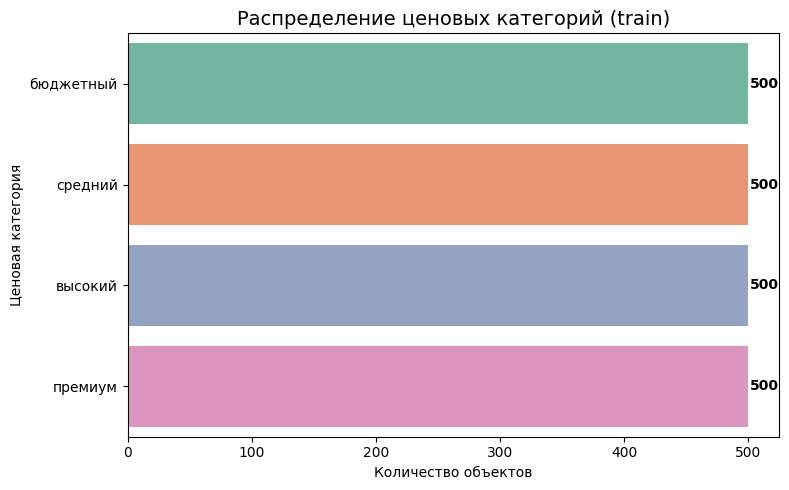

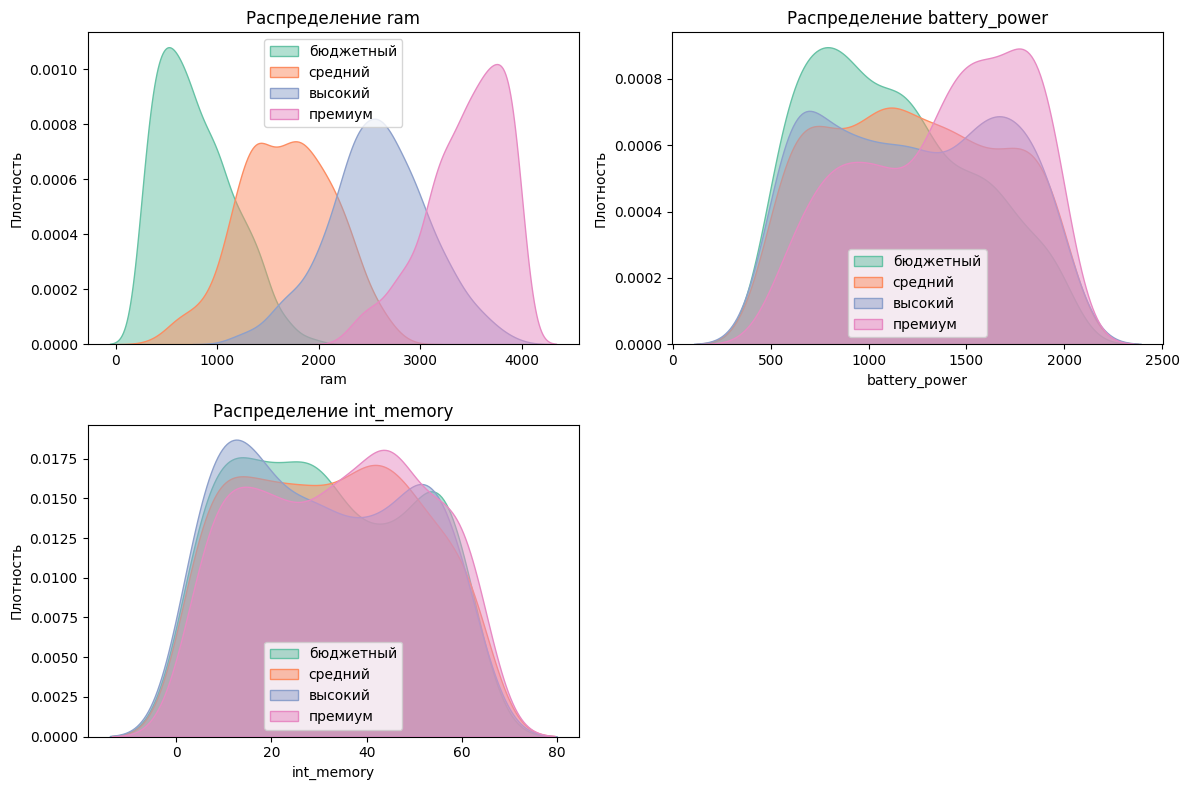

In [32]:
NEW_PALETTE = sns.color_palette("Set2", n_colors=len(CATEGORY_NAMES))

sorted_categories = sorted(CATEGORY_NAMES.keys())
price_distribution = y_train.value_counts().reindex(sorted_categories, fill_value=0)


def plot_category_distribution_mod(price_dist, cat_names: dict) -> None:
    """
    Горизонтальный barplot для распределения ценовых категорий
    """
    labels = [cat_names[i] for i in price_dist.index]
    counts = price_dist.values

    plt.figure(figsize=(8, 5))
    sns.barplot(x=counts, y=labels, palette=NEW_PALETTE)
    for i, count in enumerate(counts):
        plt.text(count + 1, i, str(count), va='center', fontweight='bold')
    plt.title("Распределение ценовых категорий (train)", fontsize=14)
    plt.xlabel("Количество объектов")
    plt.ylabel("Ценовая категория")
    plt.tight_layout()
    plt.show()


def plot_feature_distributions_mod(
    X: "pd.DataFrame",
    y: "pd.Series",
    cat_names: dict,
    features_to_plot: List[str],
) -> None:
    """
    KDE-плоты для распределения признаков по категориям
    """
    available = [f for f in features_to_plot if f in X.columns]
    n = len(available)
    cols = 2
    rows = (n + 1) // 2

    plt.figure(figsize=(cols * 6, rows * 4))

    for idx, feat in enumerate(available, start=1):
        plt.subplot(rows, cols, idx)
        for color_idx, category in enumerate(sorted(cat_names.keys())):
            mask = y == category
            values = X.loc[mask, feat]
            if values.empty:
                continue
            sns.kdeplot(
                values,
                fill=True,
                alpha=0.5,
                label=cat_names[category],
                color=NEW_PALETTE[color_idx % len(NEW_PALETTE)]
            )
        plt.title(f"Распределение {feat}", fontsize=12)
        plt.xlabel(feat)
        plt.ylabel("Плотность")
        plt.legend()

    plt.tight_layout()
    plt.show()


plot_category_distribution_mod(price_distribution, CATEGORY_NAMES)

FEATURES_TO_PLOT = ["ram", "battery_power", "int_memory"]
plot_feature_distributions_mod(X_train, y_train, CATEGORY_NAMES, FEATURES_TO_PLOT)



Разобьем на данные для валидации.

In [17]:

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

print(f"Разбиение для тренировки: {X_train_split.shape}, Валидация: {X_val.shape}")

Train split: (1600, 20), Validation: (400, 20)


# Подбор гиперпараметров для модели

Подберем оптимальные параметры для Grig Search.

In [18]:

rf_model = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight="balanced"
)

PARAM_GRID = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.5],
}

grid = GridSearchCV(
    estimator=rf_model,
    param_grid=PARAM_GRID,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train_split, y_train_split)

print("\nЛучшие параметры GridSearch:", grid.best_params_)
print(f"Лучший средний F1 (CV): {grid.best_score_:.4f}")


y_pred_grid = grid.predict(X_val)
f1_val = f1_score(y_val, y_pred_grid, average="macro")

print(f"F1 на validation: {f1_val:.4f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Лучшие параметры GridSearch: {'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Лучший средний F1 (CV): 0.8844
F1 на validation: 0.9298


Подберем оптимальные параметры для Random Search.

In [19]:

rf_model = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight="balanced"
)


PARAM_DIST = {
    "n_estimators": randint(100, 500),
    "max_depth": [5, 10, 15, 20, None],
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.8],
}


random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=PARAM_DIST,
    n_iter=50,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1,
)


random_search.fit(X_train_split, y_train_split)

print("\nЛучшие параметры Random Search:", random_search.best_params_)
print(f"Лучший средний F1 (CV): {random_search.best_score_:.4f}")


y_pred_random = random_search.predict(X_val)
f1_random = f1_score(y_val, y_pred_random, average="macro")

print(f"F1 на validation: {f1_random:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits

Лучшие параметры Random Search: {'max_depth': 20, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 225}
Лучший средний F1 (CV): 0.8843
F1 на validation: 0.9150


Подберем оптимальные параметры для Optuna.

In [20]:


def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.3, 0.5]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    }

    model = RandomForestClassifier(
        **params,
        random_state=RANDOM_STATE,
        class_weight="balanced",
    )

    scores = cross_val_score(
        model,
        X_train_split,
        y_train_split,
        cv=5,
        scoring="f1_macro"
    )

    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("\nЛучшие параметры (Optuna):")
print(study.best_params)
print(f"Лучший средний F1 (CV): {study.best_value:.4f}")

optuna_model = RandomForestClassifier(
    **study.best_params,
    random_state=RANDOM_STATE,
    class_weight="balanced",
)

optuna_model.fit(X_train_split, y_train_split)

y_pred_optuna = optuna_model.predict(X_val)
f1_optuna = f1_score(y_val, y_pred_optuna, average="macro")

print(f"F1 на validation: {f1_optuna:.4f}")

[I 2025-11-14 14:18:08,157] A new study created in memory with name: no-name-64b5e940-d5f0-4fc4-9049-cebbb3890559
[I 2025-11-14 14:18:19,693] Trial 0 finished with value: 0.8759412096895162 and parameters: {'n_estimators': 399, 'max_depth': 30, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 0.3, 'bootstrap': True}. Best is trial 0 with value: 0.8759412096895162.
[I 2025-11-14 14:18:23,390] Trial 1 finished with value: 0.8597303415515267 and parameters: {'n_estimators': 144, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8759412096895162.
[I 2025-11-14 14:18:33,967] Trial 2 finished with value: 0.8548932222768088 and parameters: {'n_estimators': 437, 'max_depth': 22, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8759412096895162.
[I 2025-11-14 14:18:37,073] Trial 3 finished with value: 0.855149406477591


Лучшие параметры (Optuna):
{'n_estimators': 383, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': False}
Лучший средний F1 (CV): 0.8776
F1 на validation: 0.9146


Выберем лучшую модель и обучим ее.

In [25]:


methods_comparison = {
    "Grid Search": f1_val,
    "Random Search": f1_random,
    "Optuna": f1_optuna,
}

for method, score in methods_comparison.items():
    print(f"{method}: F1-score = {score:.4f}")

best_method = max(methods_comparison, key=methods_comparison.get)
print(f"\nЛучший метод по validation: {best_method}")

if best_method == "Grid Search":
    best_model = grid.best_estimator_ if "grid" in globals() else grid_search.best_estimator_
    best_params = grid.best_params_ if "grid" in globals() else grid_search.best_params_
elif best_method == "Random Search":
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
else:
    best_model = optuna_model
    best_params = study.best_params

print(f"\nИспользуется модель от {best_method}")
print("Лучшие параметры:", best_params)

best_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)

if ID_COL in df_test.columns:
    submission = pd.DataFrame({"id": df_test[ID_COL], "price_range": y_test_pred})
else:
    submission = pd.DataFrame({"price_range": y_test_pred})


y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average="macro")

print(f"\nAccuracy на тренировочных данных: {train_accuracy:.4f}")
print(f"F1-score (macro) на тренировочных данных: {train_f1:.4f}")



Grid Search: F1-score = 0.9298
Random Search: F1-score = 0.9150
Optuna: F1-score = 0.9146

Лучший метод по validation: Grid Search

Используется модель от Grid Search
Лучшие параметры: {'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Accuracy на тренировочных данных: 1.0000
F1-score (macro) на тренировочных данных: 1.0000


# Реализация калькулятора, который показывает `локальную интерпретацию` с помощью LIME и `глобальную интерпретацию` с помощью SHAP

In [27]:

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=features,
    class_names=[CATEGORY_NAMES[i] for i in sorted(CATEGORY_NAMES.keys())],
    mode="classification",
    random_state=RANDOM_STATE,
)

X_train_sample = X_train.sample(
    n=min(100, len(X_train)),
    random_state=RANDOM_STATE
)

explainer_shap = shap.TreeExplainer(best_model)
shap_values = explainer_shap.shap_values(X_train_sample)

Реализация калькулятора предсказания ценовой категории телефона.

In [28]:
def phone_price_calculator(model, data, features, instance_idx, category_names):
    """
    Калькулятор предсказания ценовой категории телефона.
    Выводит предсказанную категорию, вероятности по всем классам,
    ключевые характеристики, и возвращает LIME объяснение.

    Параметры:
    - model: обученный классификатор
    - data: pd.DataFrame с признаками
    - features: список признаков, используемых моделью
    - instance_idx: индекс анализируемого телефона
    - category_names: словарь {int: str} с названиями категорий
    """
    instance = data.iloc[instance_idx:instance_idx+1]

    prediction = model.predict(instance)[0]
    probabilities = model.predict_proba(instance)[0]

    print(f"Предсказанная категория: {category_names[prediction]}")
    print("Вероятности категорий:")
    for i, prob in enumerate(probabilities):
        print(f"  {category_names[i]}: {prob:.3f}")

    important_features = ["ram", "battery_power", "px_height", "px_width", "int_memory", "pc"]
    print("\nОсновные характеристики:")
    for feature in important_features:
        if feature in instance.columns:
            print(f"  {feature}: {instance[feature].values[0]}")

    print(f"\nLIME Объяснение {category_names[prediction]}?")
    exp = explainer_lime.explain_instance(
        instance.values[0],
        model.predict_proba,
        num_features=10,
        top_labels=1
    )

    return exp, prediction, probabilities


Предсказанная категория: премиум
Вероятности категорий:
  бюджетный: 0.000
  средний: 0.010
  высокий: 0.267
  премиум: 0.723

Основные характеристики:
  ram: 3476
  battery_power: 1043
  px_height: 226
  px_width: 1412
  int_memory: 5
  pc: 16

LIME Объяснение премиум?

LIME ANALYSIS FOR PREDICTION: премиум
                          Feature  Contribution     Sign
                    ram > 3064.50      0.768651 positive
              px_height <= 282.75     -0.045465 negative
851.75 < battery_power <= 1226.00     -0.042809 negative
    1247.00 < px_width <= 1633.00      0.026138 positive
               mobile_wt > 170.00     -0.020906 negative
                     wifi <= 0.00      0.009130 positive
                   four_g <= 0.00     -0.007067 negative
              int_memory <= 16.00     -0.006682 negative
      0.00 < touch_screen <= 1.00     -0.006006 negative
                  n_cores <= 3.00      0.005728 positive


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


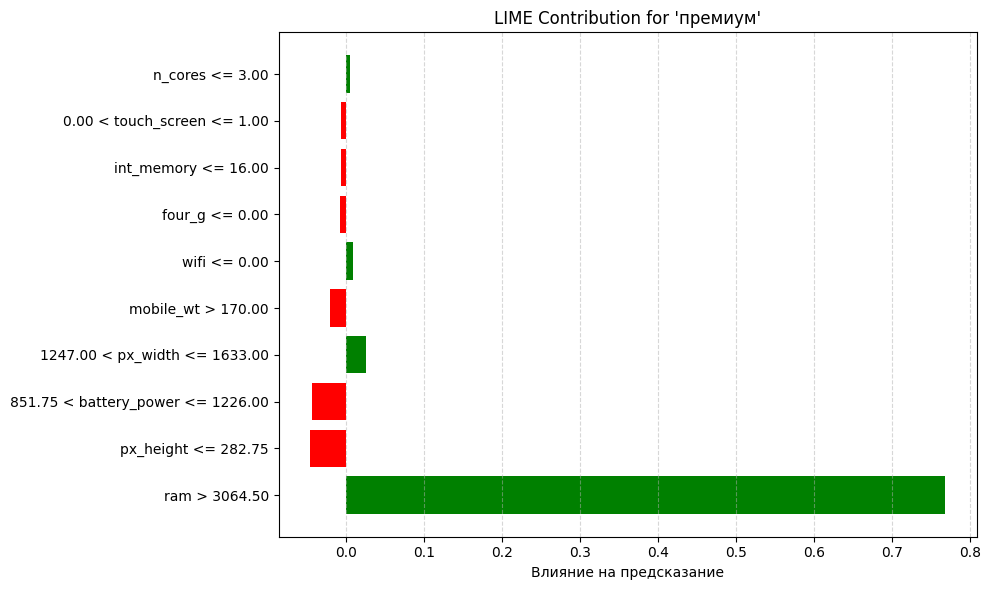

Ошибка при визуализации SHAP: All arrays must be of the same length


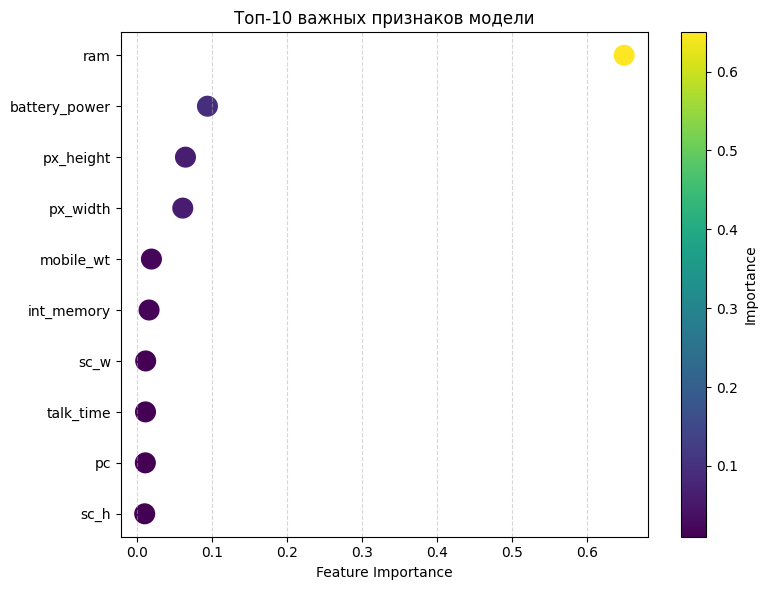


=== Top Features Table ===
      Feature  Importance
          ram    0.649674
battery_power    0.094018
    px_height    0.064715
     px_width    0.061108
    mobile_wt    0.019311
   int_memory    0.016171
         sc_w    0.011663
    talk_time    0.011424
           pc    0.011194
         sc_h    0.010345


In [30]:


def display_lime_report(exp, pred, category_names, top_n=10):
    """Вывод LIME в виде таблицы с цветовой индикацией влияния признаков"""

    explanation_list = exp.as_list(label=pred)
    df = pd.DataFrame(explanation_list, columns=["Feature", "Contribution"])
    df = df.head(top_n)


    df["Sign"] = df["Contribution"].apply(lambda x: "positive" if x>0 else "negative")

    print(f"\nLIME ANALYSIS FOR PREDICTION: {category_names[pred]}")
    print(df[["Feature", "Contribution", "Sign"]].to_string(index=False))

    plt.figure(figsize=(10, 6))
    colors = df["Contribution"].apply(lambda x: "green" if x>0 else "red")
    plt.barh(df["Feature"], df["Contribution"], color=colors)
    plt.xlabel("Влияние на предсказание")
    plt.title(f"LIME Contribution for '{category_names[pred]}'")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def display_shap_summary(shap_values, X_sample, features, category_names):
    """Горизонтальная SHAP summary визуализация по классам"""

    class_names_list = [category_names[i] for i in sorted(category_names.keys())]

    for i, class_name in enumerate(class_names_list):
        shap_sum = np.abs(shap_values[i]).mean(axis=0)
        df = pd.DataFrame({"Feature": features, "Mean_SHAP": shap_sum}).sort_values("Mean_SHAP", ascending=True)

        plt.figure(figsize=(8, 6))
        plt.scatter(df["Mean_SHAP"], df["Feature"], s=100, color="teal")
        plt.xlabel("Среднее абсолютное SHAP значение")
        plt.title(f"SHAP Feature Importance для '{class_name}'")
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


def display_feature_importance(model, features, top_n=10):
    """Dot-plot для топ-N признаков модели"""
    df = pd.DataFrame({
        "Feature": features,
        "Importance": model.feature_importances_
    }).sort_values("Importance", ascending=True)

    df_top = df.tail(top_n)

    plt.figure(figsize=(8, 6))
    plt.scatter(df_top["Importance"], df_top["Feature"], s=200, c=df_top["Importance"], cmap="viridis")
    plt.colorbar(label="Importance")
    plt.xlabel("Feature Importance")
    plt.title(f"Топ-{top_n} важных признаков модели")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("\n=== Top Features Table ===")
    print(df_top.sort_values("Importance", ascending=False).to_string(index=False))


try:
    exp, pred, prob = phone_price_calculator(best_model, X_test, features, 0, CATEGORY_NAMES)
    display_lime_report(exp, pred, CATEGORY_NAMES)
except Exception as e:
    print(f"Ошибка при работе LIME: {e}")

try:
    display_shap_summary(shap_values, X_train_sample, features, CATEGORY_NAMES)
except Exception as e:
    print(f"Ошибка при визуализации SHAP: {e}")

display_feature_importance(best_model, features, top_n=10)
